## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [112]:
#Import libraries

import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import kstest

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

#For API (QUES 3)
import requests as re
import time
import os
import json
from urllib.request import urlopen

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
pd.set_option('display.max_columns', None) # Display all the columns
sns.set(color_codes=True)

In [4]:
df = pd.read_csv("data/cleanflight.csv")
dfraw = pd.read_csv("data/flightdata.csv")


In [5]:
df = df.drop(['Unnamed: 0'], axis=1)


In [112]:
df.head()

,Unnamed: 0,origin_airport_id,dest_airport_id,crs_dep_time,dep_delay,taxi_out,taxi_in,crs_arr_time,arr_delay,crs_elapsed_time,distance,first_dep_time,month,hr_dep,hr_arr,cat_delay,distance_catg_Short,distance_catg_Medium,distance_catg_Long,time_of_day_Wee Hours,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Night
4,4,12217,11298,1536,108.0,15.0,19.0,1749,115.0,133.0,603.0,0.0,12,15,17,1,0,1,0,0,0,1,0
13,14,12478,10785,2246,95.0,16.0,4.0,3,86.0,77.0,266.0,0.0,5,22,0,1,1,0,0,0,0,0,1
17,18,12266,15624,1805,149.0,17.0,10.0,1952,148.0,107.0,528.0,0.0,9,18,19,1,1,0,0,0,0,0,1
25,26,10721,14524,1510,51.0,62.0,7.0,1707,86.0,117.0,474.0,0.0,12,15,17,1,1,0,0,0,0,1,0
35,36,12448,10397,739,249.0,14.0,8.0,1000,243.0,81.0,341.0,0.0,5,7,10,1,1,0,0,0,1,0,0


#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [63]:
#Our N is larger than 5000, so let's use the Shapiro Wilk test, but also double check with a KS test, as this is better with a larger N
y = df.dep_delay
x = y[y.between(y.quantile(.05), y.quantile(.95))] # remove outliers outliers

shap_wilks = shapiro(x)

c:\Users\k_mah\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [64]:
shap_wilks

ShapiroResult(statistic=0.6907292008399963, pvalue=0.0)

In [65]:
ks_statistic, p_value = kstest(x, 'norm')
print(ks_statistic, p_value)

0.5366977553757645 0.0


c:\Users\k_mah\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\k_mah\anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Departure delays distribution')

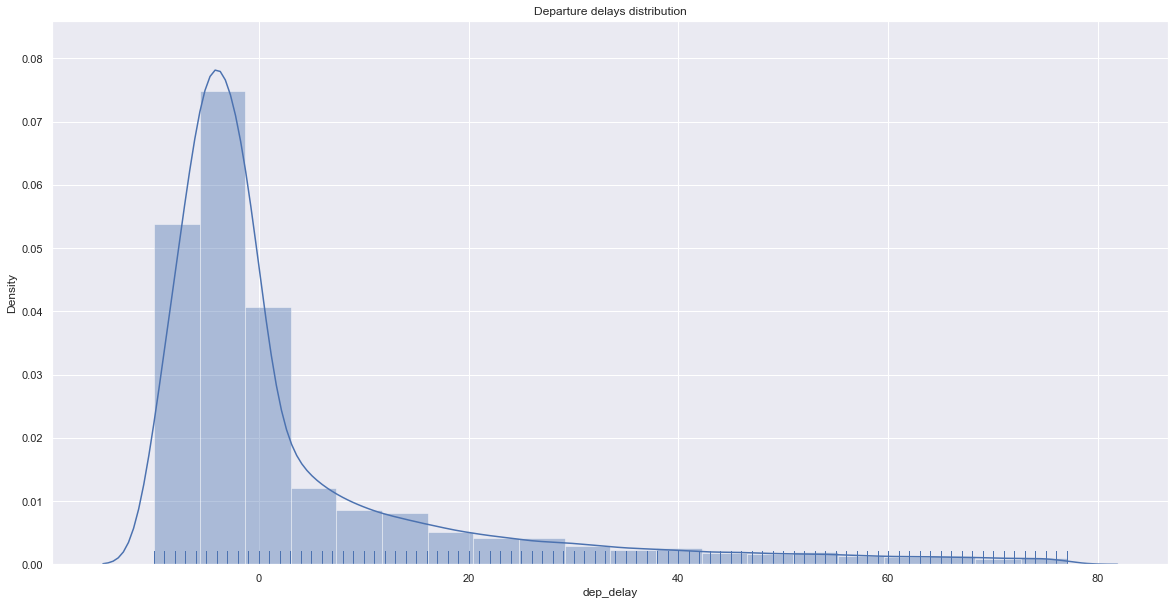

In [66]:
#Histogram
plt.figure(figsize=(20,10))
sns.distplot(x, bins=20, rug=True).set_title('Departure delays distribution')

The shapiro wilks test statistic (W) is is not close to 1, and nor is it for the KStest - and visually, we can see that the distribution is not normal. But if we look carefully, this includes flights that left early. Let's try this again excluding those.

In [67]:

b = df.dep_delay
a = b[b.between(0, b.quantile(.95))] # remove outliers outliers

shap_wilks = shapiro(a)

c:\Users\k_mah\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [68]:
shap_wilks

ShapiroResult(statistic=0.8260799050331116, pvalue=0.0)

In [69]:
ks_statistic, p_value = kstest(x, 'norm')
print(ks_statistic, p_value)

0.5366977553757645 0.0


c:\Users\k_mah\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\k_mah\anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Departure delays distribution')

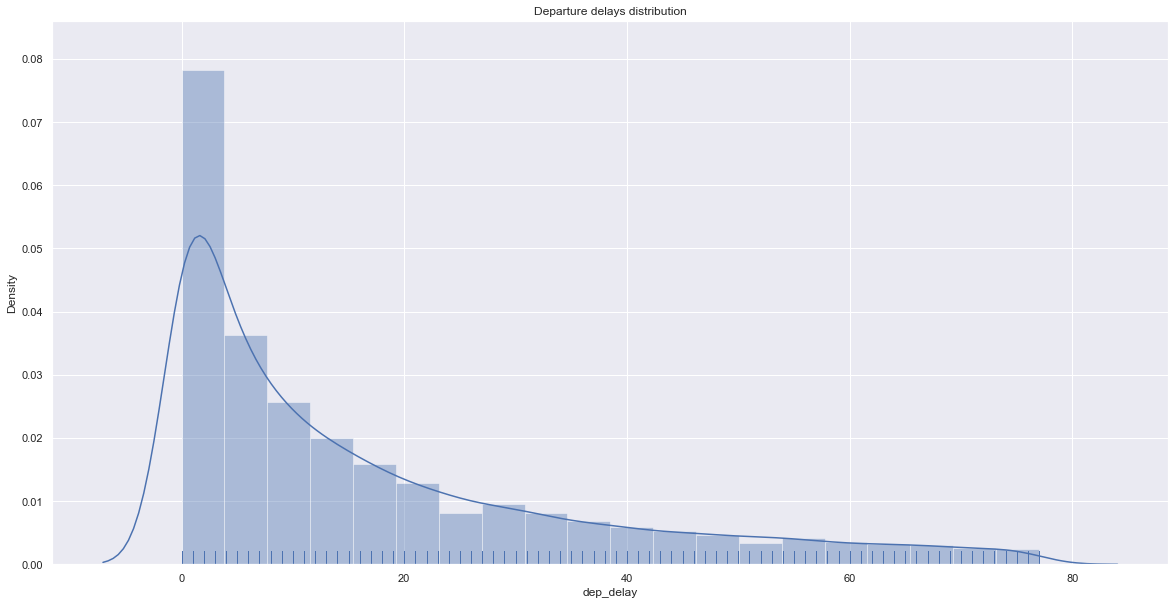

In [70]:
#Histogram
plt.figure(figsize=(20,10))
sns.distplot(a, bins=20, rug=True).set_title('Departure delays distribution')

If we look at just delays and not also negative values (ie flights that left early) we can see that visually the distribution looks to be exponential, and our test results very much suggest that it isn't normal.

In [71]:
#Let's also quickly look at arrival delays
b = df.arr_delay
a = b[b.between(b.quantile(.05), b.quantile(.95))] # remove outliers outliers

shap_wilks = shapiro(a)

c:\Users\k_mah\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [72]:
shap_wilks

ShapiroResult(statistic=0.8590622544288635, pvalue=0.0)

c:\Users\k_mah\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\k_mah\anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Arrival delays distribution')

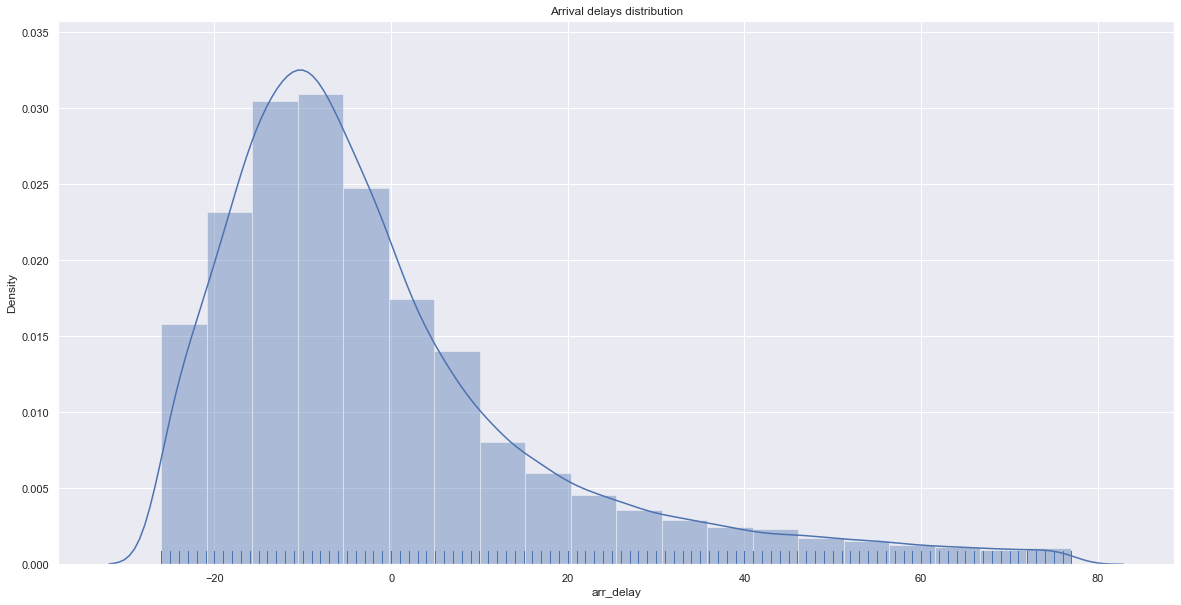

In [73]:
#Histogram
plt.figure(figsize=(20,10))
sns.distplot(a, bins=20, rug=True).set_title('Arrival delays distribution')

#not quite normal though W is closer to 1.

The mean flight delay is 5.7 minutes.
If we only consider delayed flights, the mean flight delay is 40.6 minutes.


<AxesSubplot:xlabel='arr_delay'>

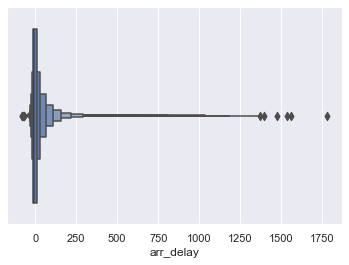

In [74]:
#Let's look at the means
delay = df['arr_delay'].mean()
actual_delay = df[df['arr_delay']>0]['arr_delay'].mean()

print(f'The mean flight delay is {delay:.1f} minutes.')
print(f'If we only consider delayed flights, the mean flight delay is {actual_delay:.1f} minutes.')
        
sns.boxenplot(data = df, x = "arr_delay")

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [75]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

median_arr = df[["month", "arr_delay"]].groupby(df["month"]).median()
median_arr.index = months
mean_arr = df[["month", "arr_delay"]].groupby(df["month"]).mean()
mean_arr.index = months

median_dep = df[["month", "dep_delay"]].groupby(df["month"]).median()
median_dep.index = months
mean_dep = df[["month", "dep_delay"]].groupby(df["month"]).mean()
mean_dep.index = months

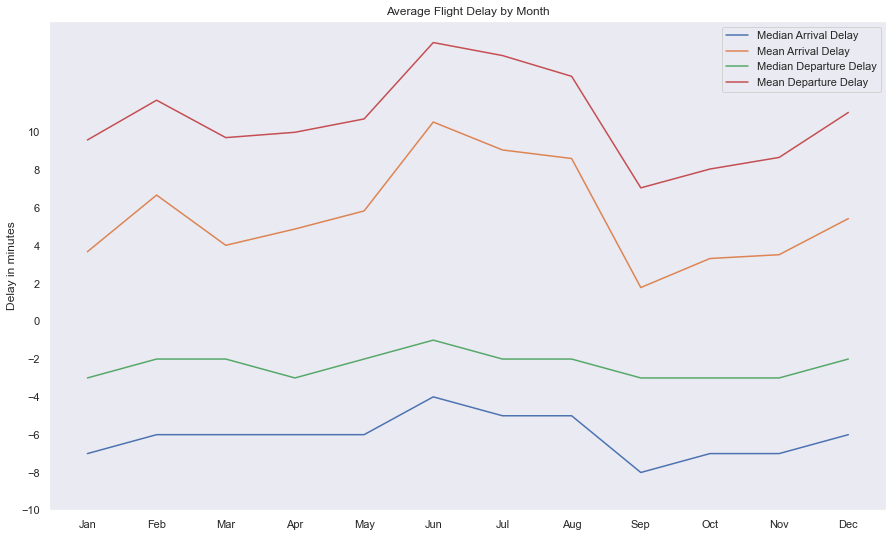

In [76]:
figure = plt.figure(figsize=(15,9))

plt.plot(median_arr.index, median_arr["arr_delay"], label="Median Arrival Delay")
plt.plot(mean_arr.index, mean_arr["arr_delay"], label="Mean Arrival Delay")
plt.plot(median_dep.index, median_dep["dep_delay"], label="Median Departure Delay")
plt.plot(mean_dep.index, mean_dep["dep_delay"], label="Mean Departure Delay")

plt.ylabel("Delay in minutes")
plt.yticks(range(-10, 12, 2))
plt.grid()
plt.legend()
plt.title("Average Flight Delay by Month")

plt.show()

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [60]:
#Pick flights with weather delays of more than 15 minutes
dfweather = dfraw[dfraw.weather_delay >= 15]

In [75]:
#Pick a sample - visual crossing allows 1000 pulls 
dfweather = dfweather.sample(n=200, random_state=42)

In [76]:
#Time to 24hr clock and formatted
dfweather['crs_dep_time'] = dfweather['crs_dep_time'].apply(lambda x: '{0:0>4}'.format(x))
dfweather
# dfweather['crs_dep_time'] = pd.to_datetime(dfweather['crs_dep_time'], format='%H%M').dt.strftime('%H:%M')
# dfweather['fl_date'] = pd.to_datetime(dfweather['fl_date'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')


,Unnamed: 0,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,tail_num,origin_airport_id,origin_city_name,dest_airport_id,dest_city_name,crs_dep_time,dep_delay,taxi_out,taxi_in,crs_arr_time,arr_delay,cancelled,cancellation_code,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,month,year,day
5918,5918,2019-03-24,UA,5726,N788SK,11292,"Denver, CO",10372,"Aspen, CO",13:26,97.0,15.0,3.0,1422,88.0,0.0,NaN,0.0,56.0,47.0,29.0,125.0,0.0,88.0,0.0,0.0,0.0,NaN,NaN,NaN,3,2019,24
49095,49095,2019-02-12,NK,917,N639NK,11298,"Dallas/Fort Worth, TX",11292,"Denver, CO",17:58,114.0,16.0,7.0,1907,113.0,0.0,NaN,0.0,129.0,128.0,105.0,641.0,9.0,24.0,2.0,0.0,78.0,NaN,NaN,NaN,2,2019,12
51560,51560,2018-07-21,DL,2124,N1402A,10397,"Atlanta, GA",12892,"Los Angeles, CA",08:30,50.0,23.0,8.0,1009,46.0,0.0,NaN,0.0,279.0,275.0,244.0,1947.0,0.0,46.0,0.0,0.0,0.0,NaN,NaN,NaN,7,2018,21
25431,25431,2018-09-18,AA,2059,N723UW,10721,"Boston, MA",11057,"Charlotte, NC",05:00,502.0,27.0,8.0,714,505.0,0.0,NaN,0.0,134.0,137.0,102.0,728.0,300.0,202.0,3.0,0.0,0.0,NaN,NaN,NaN,9,2018,18
13412,13412,2019-03-31,DL,2225,N582NW,10397,"Atlanta, GA",12889,"Las Vegas, NV",08:22,69.0,17.0,7.0,954,53.0,0.0,NaN,0.0,272.0,256.0,232.0,1747.0,0.0,53.0,0.0,0.0,0.0,NaN,NaN,NaN,3,2019,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44144,44144,2019-06-28,UA,264,N37273,13485,"Madison, WI",11292,"Denver, CO",07:00,37.0,16.0,5.0,826,27.0,0.0,NaN,0.0,146.0,136.0,115.0,826.0,0.0,27.0,0.0,0.0,0.0,NaN,NaN,NaN,6,2019,28
94621,94621,2019-02-20,AA,3347,N532EA,10140,"Albuquerque, NM",13930,"Chicago, IL",07:07,116.0,17.0,8.0,1054,101.0,0.0,NaN,0.0,167.0,152.0,127.0,1118.0,0.0,101.0,0.0,0.0,0.0,NaN,NaN,NaN,2,2019,20
92177,92177,2019-01-21,DL,1196,N3768,14869,"Salt Lake City, UT",14057,"Portland, OR",11:15,49.0,36.0,5.0,1227,52.0,0.0,NaN,0.0,132.0,135.0,94.0,630.0,0.0,49.0,3.0,0.0,0.0,NaN,NaN,NaN,1,2019,21
43654,43654,2019-10-10,DL,3659,N440SW,14457,"Rapid City, SD",13487,"Minneapolis, MN",16:24,61.0,58.0,20.0,1905,114.0,0.0,NaN,0.0,101.0,154.0,76.0,489.0,0.0,53.0,53.0,0.0,8.0,NaN,NaN,NaN,10,2019,10


In [90]:
def get_weather(city_name, fl_date):
    depDT = fl_date
    key = os.environ['VISUAL_CROSSING_API'] 
    url = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history?aggregateHours=1&combinationMethod=aggregate&startDateTime={depDT}T00%3A00%3A00&endDateTime={depDT}T00%3A00%3A00&maxStations=-1&maxDistance=-1&contentType=json&unitGroup=metric&locationMode=single&key={key}&dataElements=default&locations={city_name.strip()[:-2]}'
    res = re.get(url)
   
    data = json.loads(res.text) 

    try:
        return data['location']['values'][0]['conditions']
    except (KeyError):
        return data

In [92]:
dfweather['origin_weather'] = dfweather.apply(lambda x: get_weather(x['origin_city_name'], x['fl_date'], x['crs_dep_time']), axis= 1)

In [94]:
#saving it so we don't keep pulling from the API
dfweather.to_csv('data/weather.csv')

In [104]:
dfweather = pd.read_csv("data/weather.csv")

In [105]:
#Seems like our sample didn't contain any snowy days. Whoops.
dfweather['origin_weather'].unique()

array(['Clear', 'Partially cloudy', 'Overcast', 'Rain, Overcast',
       'Rain, Partially cloudy'], dtype=object)

In [106]:
dfweather = dfweather[['origin_weather', 'arr_delay']]

In [107]:
dfweather.head()

,origin_weather,arr_delay
0,Clear,88.0
1,Partially cloudy,113.0
2,Clear,46.0
3,Partially cloudy,505.0
4,Overcast,53.0


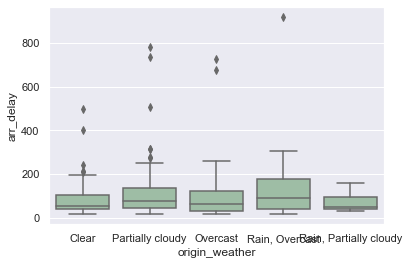

In [111]:
ax = sns.boxplot(x='origin_weather', y='arr_delay', data=dfweather, color='#99c2a2')
plt.show()

In [113]:
#Let's do a one-factor anova to see if the groups are different
# Ordinary Least Squares (OLS) model
model = ols('arr_delay ~ C(origin_weather)', data=dfweather).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
#The p-value is around 0.35, and so this isn't really significant, but the sample size is quite small for an anova so it may be that if 
# we were able to use the full set there would be significance. Also, the sample didn't have any snowy days, so a larger sample would really be necessary here.

,sum_sq,df,F,PR(>F)
C(origin_weather),8.114811e+04,4.0,1.123319,0.346721
Residual,3.521680e+06,195.0,NaN,NaN


#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [77]:
df_taxi = df[['crs_dep_time', 'arr_delay', 'taxi_out']]

In [78]:
df_taxi['hr_dep'] = df_taxi['crs_dep_time'] // 100 #Extract the hour of departure
df_dep = df_taxi.groupby("hr_dep")['taxi_out'].mean()

C:\Users\k_mah\AppData\Local\Temp\ipykernel_764\3403871304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_taxi['hr_dep'] = df_taxi['crs_dep_time'] // 100 #Extract the hour of departure


<AxesSubplot:xlabel='crs_dep_time', ylabel='Count'>

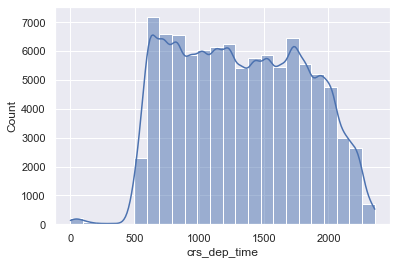

In [79]:
sns.histplot(data = df_taxi, x = "crs_dep_time",bins = 24, label = "Departure time", kde=True)

<AxesSubplot:xlabel='taxi_out', ylabel='Count'>

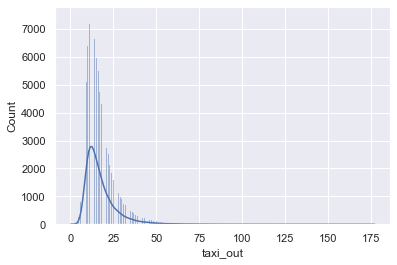

In [80]:
sns.histplot(data = df_taxi, x = "taxi_out", label = "Taxi time on outgoing", kde=True)

Text(0, 0.5, 'Arrival delay')

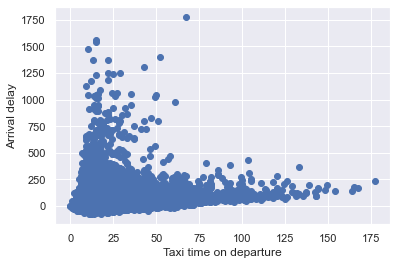

In [81]:
plt.scatter(df_taxi['taxi_out'], df_taxi['arr_delay'])
plt.xlabel("Taxi time on departure")
plt.ylabel("Arrival delay")

In [82]:
# Does time of day affect delays?
flight_delay_time = 20
delay = df_taxi[df_taxi['arr_delay']>flight_delay_time].groupby('hr_dep').count().sort_values(by=['arr_delay'], ascending=False)
total = df_taxi.groupby('hr_dep').count().sort_values(by=['arr_delay'], ascending=False)

mon_df = pd.merge(delay, total, how = "inner", on='hr_dep')
mon_df = mon_df.rename(columns={'arr_delay_x': "total_delays", 'arr_delay_y': "total_flights"})
mon_df['percent_delayed'] = mon_df['total_delays']/mon_df['total_flights']
mon_df.sort_values(by=['percent_delayed'], ascending=False)['percent_delayed']

hr_dep
3     0.240000
19    0.229094
18    0.228329
20    0.219184
21    0.218364
17    0.217493
2     0.217391
16    0.200184
15    0.191420
22    0.185143
14    0.181217
13    0.166975
23    0.159483
4     0.153846
12    0.153785
11    0.135100
10    0.127836
1     0.123457
0     0.117647
9     0.114330
8     0.100839
7     0.093532
6     0.078060
5     0.062282
Name: percent_delayed, dtype: float64

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

<AxesSubplot:>

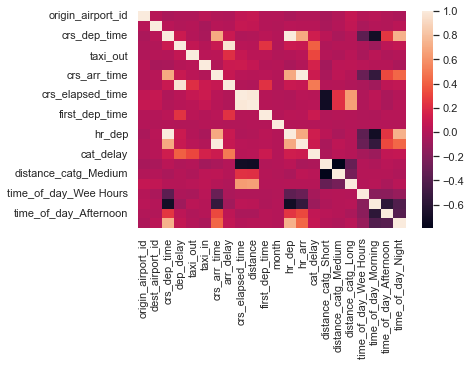

In [83]:
sns.heatmap(df.corr())

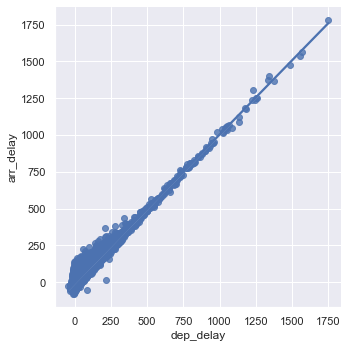

In [84]:
sns.lmplot(x="dep_delay", y="arr_delay", data=df)

In [85]:
stats.pearsonr(df['dep_delay'], df['arr_delay'])

(0.9642410779110518, 0.0)

Visually, we can see on hour heatmap and scatter plot that the two are almost completely correlated, and our pearson correlation shows the same

In [86]:
#Looking at the arrival delays we can see that around 76% of flights that had an arrival delay also had a departure delay and around 80% of flights that had
# a departure delay also had an arrival delay (a delay in this case is more than 10 minutes)
arrival_delay = df["arr_delay"].gt(10).sum()
depart_delay = df["dep_delay"].gt(10).sum()
both_delayed = (df["arr_delay"].gt(10) & df["dep_delay"].gt(10)).sum()
print(both_delayed/arrival_delay)
print(both_delayed/depart_delay)

0.7604864052466184
0.7946509303764336


#### **Task 6**: How many states cover 50% of US air traffic? 

In [123]:
#Get states from the origin city
dfstate = dfraw
dfstate['origin_state'] = dfstate['origin_city_name'].str[-2:]
dfstate['dest_state'] = dfstate['dest_city_name'].str[-2:]

In [129]:
#percentage of flights by origin
dfstate['origin_state'].value_counts(normalize=True) * 100


CA    11.053
TX     9.880
FL     7.231
IL     6.359
GA     5.159
NY     5.110
NC     4.698
CO     4.002
WA     2.916
PA     2.901
MI     2.898
DC     2.892
AZ     2.535
NV     2.377
OH     2.293
MN     2.178
NJ     2.090
MA     1.923
MO     1.837
TN     1.777
UT     1.609
HI     1.485
MD     1.399
OR     1.369
LA     1.139
VA     0.946
IN     0.929
WI     0.845
SC     0.812
OK     0.575
KY     0.535
AL     0.524
AK     0.508
NE     0.429
ID     0.422
AR     0.415
IA     0.399
PR     0.383
NM     0.368
CT     0.365
MT     0.365
ND     0.301
RI     0.281
ME     0.276
KS     0.211
MS     0.204
SD     0.203
VT     0.155
NH     0.154
WY     0.121
WV     0.087
VI     0.049
TT     0.028
Name: origin_state, dtype: float64

In [130]:
#percentage of flights by origin
dfstate['dest_state'].value_counts(normalize=True) * 100

CA    10.928
TX     9.811
FL     7.274
IL     6.343
GA     5.303
NY     5.199
NC     4.472
CO     3.899
PA     2.970
DC     2.933
WA     2.829
MI     2.715
AZ     2.607
NV     2.409
OH     2.287
MN     2.237
NJ     2.132
MO     1.941
MA     1.868
TN     1.749
HI     1.524
UT     1.504
OR     1.457
MD     1.337
LA     1.075
VA     0.976
IN     0.955
WI     0.914
SC     0.888
OK     0.598
AL     0.558
AK     0.528
KY     0.521
IA     0.422
ID     0.418
NE     0.416
NM     0.404
AR     0.397
MT     0.389
CT     0.373
PR     0.349
ND     0.300
ME     0.298
RI     0.239
SD     0.209
MS     0.200
KS     0.197
VT     0.162
NH     0.161
WY     0.145
WV     0.095
VI     0.055
TT     0.030
Name: dest_state, dtype: float64

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

In [87]:
import scipy.stats as st
#Use a t-test for this
df["arr_dep_delay_diff"] = df['arr_delay'] - df['dep_delay']
#I picked less than 5 minutes delay as "no delay"...I mean, it's 5 minutes.
no_delay = df[df['dep_delay'] < 5]
delay = df[df['dep_delay'] > 5]
delay_ttest = st.ttest_ind(no_delay.arr_dep_delay_diff, delay.arr_dep_delay_diff, equal_var=False)
print(delay_ttest)
# No difference (very high p-value) in the original run - a very low p-value here. Look at data, just to be sure (mean of delay_diff is the relavant variable)

Ttest_indResult(statistic=-5.42088683315952, pvalue=5.966477519876454e-08)


In [88]:
no_delay_check = no_delay[['dep_delay', 'arr_dep_delay_diff']]
no_delay_check.describe()

,dep_delay,arr_dep_delay_diff
count,71060.000000,71060.000000
mean,-4.324993,-5.224106
std,3.988035,12.600707
min,-46.000000,-70.000000
25%,-7.000000,-13.000000
50%,-4.000000,-6.000000
75%,-2.000000,1.000000
max,4.000000,143.000000


In [89]:
no_delay_check = no_delay[['dep_delay', 'arr_dep_delay_diff']]
no_delay_check.describe()

,dep_delay,arr_dep_delay_diff
count,71060.000000,71060.000000
mean,-4.324993,-5.224106
std,3.988035,12.600707
min,-46.000000,-70.000000
25%,-7.000000,-13.000000
50%,-4.000000,-6.000000
75%,-2.000000,1.000000
max,4.000000,143.000000


In [90]:

delay_check = delay[['dep_delay', 'arr_dep_delay_diff']]
delay_check.describe() 

,dep_delay,arr_dep_delay_diff
count,25693.000000,25693.000000
mean,52.621609,-4.628420
std,81.979356,15.900919
min,6.000000,-194.000000
25%,13.000000,-14.000000
50%,27.000000,-7.000000
75%,61.000000,2.000000
max,1752.000000,168.000000


#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [116]:
flight_type = []

def get_flight_haul_type(sched_flighttime):
    for element in sched_flighttime:
        flight_duration = round((element/60), 2)
        if flight_duration <= 3:
            flight_type.append("short-haul")
        elif flight_duration >= 6:
            flight_type.append('long-haul')
        else:
            flight_type.append('medium-haul')

get_flight_haul_type(df['crs_elapsed_time'])
flight_type2 = pd.Series(flight_type)
df = df.merge(flight_type2.rename("flight_haul"), left_index=True, right_index=True)
df['hr_dep'].groupby(df['flight_haul']).mean()

flight_haul
long-haul      13.545455
medium-haul    14.469602
short-haul     14.400915
Name: hr_dep, dtype: float64

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

In [93]:
# Get 10 busiest airport origin by flight count
busy_airports_dep = dfraw[['origin_city_name','origin_airport_id']]
busy_airports_dep = dfraw.groupby(['origin_city_name','origin_airport_id'])['origin_airport_id'].count().sort_values(ascending=False).head(10)

busy_airports_dep

origin_city_name       origin_airport_id
Chicago, IL            13930                5014
Atlanta, GA            10397                4804
Dallas/Fort Worth, TX  11298                3772
Denver, CO             11292                3583
Charlotte, NC          11057                3240
Los Angeles, CA        12892                3087
Seattle, WA            14747                2425
San Francisco, CA      14771                2355
Detroit, MI            11433                2291
Houston, TX            12266                2246
Name: origin_airport_id, dtype: int64

In [94]:
# Get 10 busiest airport origin by flight count
busy_airports_arr = dfraw[['dest_city_name','dest_airport_id']]
busy_airports_arr = dfraw.groupby(['dest_city_name','dest_airport_id'])['dest_airport_id'].count().sort_values(ascending=False).head(10)

busy_airports_arr

dest_city_name         dest_airport_id
Atlanta, GA            10397              4959
Chicago, IL            13930              4929
Dallas/Fort Worth, TX  11298              3592
Denver, CO             11292              3450
Los Angeles, CA        12892              3198
Charlotte, NC          11057              3017
Seattle, WA            14747              2317
Houston, TX            12266              2272
Phoenix, AZ            14107              2211
San Francisco, CA      14771              2192
Name: dest_airport_id, dtype: int64

In [106]:
delay = df.groupby("origin_airport_id")["arr_delay"].mean()
common_arpts = df.groupby("origin_airport_id")["arr_delay"].count()

n = 10
traffic = (common_arpts.sort_values(ascending=False).head(n).sum()/common_arpts.sort_values(ascending=False).sum())*100
print(f"The top {n} origin airports account for {traffic:.1f}% of the number of flights.")

The top 10 origin airports account for 36.1% of the number of flights.


In [107]:
#Again, only look at actual "delays", where the flight lands later than it was supposed to
df = df[df['arr_delay']>20]

delay = df.groupby("origin_airport_id")["arr_delay"].mean()
common_arpts = df.groupby("origin_airport_id")["arr_delay"].count()
n = 10
traffic = (common_arpts.sort_values(ascending=False).head(n).sum()/common_arpts.sort_values(ascending=False).sum())*100
print(f"The top {n} origin airports account for {traffic:.1f}% of the number of delayed flights.")

The top 10 origin airports account for 36.1% of the number of delayed flights.


In [108]:
delay = df.groupby("dest_airport_id")["arr_delay"].mean()
common_arpts = df.groupby("dest_airport_id")["arr_delay"].count()

n = 10
traffic = (common_arpts.sort_values(ascending=False).head(n).sum()/common_arpts.sort_values(ascending=False).sum())*100
print(f"The top {n} dest airports account for {traffic:.1f}% of the number of flights.")

The top 10 dest airports account for 33.8% of the number of flights.


In [109]:
#Again, only look at actual "delays", where the flight lands later than it was supposed to
df = df[df['arr_delay']>20]

delay = df.groupby("dest_airport_id")["arr_delay"].mean()
common_arpts = df.groupby("dest_airport_id")["arr_delay"].count()
n = 10
traffic = (common_arpts.sort_values(ascending=False).head(n).sum()/common_arpts.sort_values(ascending=False).sum())*100
print(f"The top {n} dest airports account for {traffic:.1f}% of the number of delayed flights.")

The top 10 dest airports account for 33.8% of the number of delayed flights.


#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?